In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio



In [2]:
decibel = lambda x : 10.0 * np.log10(x)

In [3]:
x = np.arange(.01, 1, 1E-3)
print(x.shape)

(990,)


/Users/kaipak/anaconda3/envs/gee/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/kaipak/anaconda3/envs/gee/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

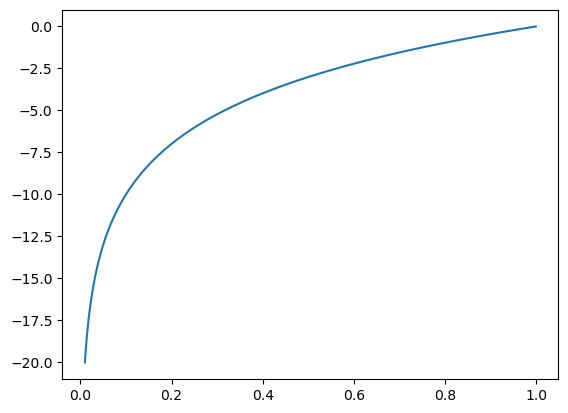

In [4]:
sns.lineplot(x=x , y=decibel(x))

In [5]:
import numpy as np
import rasterio
from scipy.fft import fft2, fftshift
import matplotlib.pyplot as plt

def preprocess_with_mask(image_path):
    """
    Preprocess the image to handle NaNs using masking.
    
    Parameters:
    - image: 2D numpy array
    
    Returns:
    - image_filled: 2D numpy masked array
    """
    with rasterio.open(hyp3_sar_fpath) as src:
        image = src.read(1)
        metadata = src.meta
    # Create a masked array where NaNs are masked
    masked_image = np.ma.masked_invalid(image)
    
    # Replace NaNs with zeros for FFT computation
    image_filled = masked_image.filled(0)
    
    return image_filled, masked_image.mask

def fft_image(image_path):
    image_filled, mask = preprocess_with_mask(image_path)

    # Apply FFT
    fft_result = fft2(image_filled)
    fft_result = fftshift(fft_result)  # Shift the zero frequency component to the center

    # Use the mask to ignore NaN regions in the FFT result (visualization)
    fft_result = np.ma.array(fft_result, mask=mask)

    # Plot the magnitude spectrum
    plt.imshow(np.log(np.abs(fft_result)), cmap='gray')
    plt.title('FFT Magnitude Spectrum (NaNs Ignored)')
    plt.colorbar()
    plt.show()

In [6]:
import numpy as np
import rasterio
from scipy.fft import fft2, fftshift
import matplotlib.pyplot as plt
from scipy.ndimage import generic_filter

def local_mean_filter(values):
    """Filter function to compute the mean of valid (non-NaN) values."""
    valid_values = values[np.isfinite(values)]
    return np.mean(valid_values) if len(valid_values) > 0 else np.nan

def preprocess_with_local_mean(image, size=5):
    """
    Preprocess the image to handle NaNs using local mean replacement.
    
    Parameters:
    - image: 2D numpy array
    - size: Size of the local window
    
    Returns:
    - image_filled: 2D numpy array with NaNs replaced
    - mask: Boolean mask indicating original NaN locations
    """
    # Create a masked array where NaNs are masked
    masked_image = np.ma.masked_invalid(image)
    
    # Replace NaNs with the local mean
    image_filled = generic_filter(masked_image.filled(0), local_mean_filter, size=size, mode='mirror')
    
    # Update the filled values with original image where it's not NaN
    image_filled = np.where(np.isnan(image), image_filled, image)
    
    return image_filled, masked_image.mask

# Example usage
with rasterio.open(hyp3_sar_fpath) as src:
    image_with_nan = src.read(1)
    metadata = src.meta

# Preprocess the image
image_filled, mask = preprocess_with_local_mean(image_with_nan)

# Apply FFT
fft_result = fft2(image_filled)
fft_result = fftshift(fft_result)  # Shift the zero frequency component to the center

# Use the mask to ignore NaN regions in the FFT result (visualization)
fft_result = np.ma.array(fft_result, mask=mask)

# Plot the magnitude spectrum
plt.imshow(np.log(np.abs(fft_result)), cmap='gray')
plt.title('FFT Magnitude Spectrum (NaNs Handled with Local Mean)')
plt.colorbar()
plt.show()


NameError: name 'hyp3_sar_fpath' is not defined

In [ ]:
# Load linear image
with rasterio.open('/Users/kaipak/datasets/SAR_comparison/snap_beta_linear/S1A_IW_GRDH_1SDV_20190105T135335_20190105T135400_025343_02CE16_1207_Cal_ML_Spk_TC.tif') as src:
    linear_image = src.read(1)

# Plot histogram
plt.hist(linear_image.flatten(), bins=256, color='blue', alpha=0.7, range=(0,.04), )
plt.title('Histogram of Linear (Beta Nought) Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.ylim((0, .15 * 1E7))
plt.show()

In [ ]:
linear_image.min()

In [ ]:
linear_image.max()

In [ ]:
fft_image(ben_sar_fpath)

In [ ]:
fft_image(hyp3_sar_fpath)

In [ ]:
# Load decibel image
with rasterio.open() as src:
    decibel_image = src.read(1)

# Plot histogram
plt.hist(decibel_image.flatten(), bins=256, color='red', alpha=0.7)
plt.title('Histogram of Decibel (dB) Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
import numpy as np
import rasterio
import random
from scipy.fft import fft2, fftshift
import matplotlib.pyplot as plt

def sample_tiles(image, tile_size=500, num_tiles=5):
    """
    Sample random tiles from the image ensuring no NaNs in the tiles.
    
    Parameters:
    - image: 2D numpy array
    - tile_size: Size of the square tiles to sample
    - num_tiles: Number of tiles to sample
    
    Returns:
    - tiles: List of sampled tiles
    """
    tiles = []
    height, width = image.shape
    
    while len(tiles) < num_tiles:
        x = random.randint(0, width - tile_size)
        y = random.randint(0, height - tile_size)
        tile = image[y:y + tile_size, x:x + tile_size]
        
        # Check if the tile contains any NaNs
        if not np.isnan(tile).any():
            tiles.append(tile)
    
    return tiles

def preprocess_with_mean(tile):
    """
    Replace NaNs in the tile with the mean of the non-NaN values.
    
    Parameters:
    - tile: 2D numpy array
    
    Returns:
    - tile_filled: 2D numpy array with NaNs replaced
    """
    mean_value = np.nanmean(tile)
    tile_filled = np.where(np.isnan(tile), mean_value, tile)
    return tile_filled

def analyze_tiles(tiles):
    """
    Perform FFT on the tiles and visualize the results.
    
    Parameters:
    - tiles: List of 2D numpy arrays (tiles)
    """
    for i, tile in enumerate(tiles):
        tile_filled = preprocess_with_mean(tile)
        fft_result = fft2(tile_filled)
        fft_result = fftshift(fft_result)
        
        # Plot the magnitude spectrum
        plt.subplot(1, len(tiles), i + 1)
        plt.imshow(np.log(np.abs(fft_result)), cmap='gray')
        plt.title(f'Tile {i+1}')
        plt.colorbar()

    plt.show()




In [ ]:
# Example usage
with rasterio.open(hyp3_sar_fpath) as src:
    image_with_nan = src.read(1)

# Sample random tiles
tiles_hyp3 = sample_tiles(image_with_nan, tile_size=500, num_tiles=5)

# Analyze the sampled tiles
analyze_tiles(tiles_hyp3)

In [ ]:
with rasterio.open(ben_sar_fpath) as src:
    image_with_nan = src.read(1)

tiles_ben = sample_tiles(image_with_nan, tile_size=500, num_tiles=5)

analyze_tiles(tiles_ben)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift

def compute_power_spectrum(image):
    """
    Compute the power spectrum of a 2D image.
    
    Parameters:
    - image: 2D numpy array
    
    Returns:
    - freq_bins: Frequency bins
    - power_spectrum: Power spectrum values corresponding to frequency bins
    """
    # Perform FFT
    fft_result = fft2(image)
    fft_result = fftshift(fft_result)  # Shift the zero frequency component to the center
    
    # Compute the power spectrum
    power_spectrum_2d = np.abs(fft_result) ** 2
    
    # Create frequency bins
    y_freqs = np.fft.fftfreq(image.shape[0])
    x_freqs = np.fft.fftfreq(image.shape[1])
    y_freqs = fftshift(y_freqs)
    x_freqs = fftshift(x_freqs)
    
    # Compute radial frequency bins
    y, x = np.meshgrid(y_freqs, x_freqs, indexing='ij')
    r = np.sqrt(x**2 + y**2)
    r = r.flatten()
    power_spectrum_2d = power_spectrum_2d.flatten()
    
    # Aggregate power in radial frequency bins
    freq_bins = np.linspace(0, np.max(r), num=5000)
    power_spectrum, _ = np.histogram(r, bins=freq_bins, weights=power_spectrum_2d)
    
    # Normalize the power spectrum
    power_spectrum /= np.histogram(r, bins=freq_bins)[0]
    
    return freq_bins[:-1], power_spectrum

def plot_frequency_power(freq_bins, power_spectrum):
    """
    Plot the frequency vs. power spectrum.
    
    Parameters:
    - freq_bins: Frequency bins
    - power_spectrum: Power spectrum values
    """
    plt.figure(figsize=(10, 6))
    plt.plot(freq_bins, np.log10(power_spectrum), label='Power Spectrum')
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    #plt.xlim((-.001,.02))
    plt.title('Frequency vs. Power Spectrum')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
image_tile_hyp3 = tiles_hyp3[3]
image_tile_ben = tiles_ben[3]

# Compute power spectrum
freq_bins, power_spectrum = compute_power_spectrum(image_tile_hyp3)

# Plot frequency vs. power
plot_frequency_power(freq_bins, power_spectrum)


In [ ]:
# Compute power spectrum
freq_bins, power_spectrum = compute_power_spectrum(image_tile_ben)

# Plot frequency vs. power
plot_frequency_power(freq_bins, power_spectrum)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift

def compute_power_spectrum(image, num_bins=100):
    fft_result = fft2(image)
    fft_result = fftshift(fft_result)
    power_spectrum_2d = np.abs(fft_result) ** 2
    
    y_freqs = np.fft.fftfreq(image.shape[0])
    x_freqs = np.fft.fftfreq(image.shape[1])
    y_freqs = fftshift(y_freqs)
    x_freqs = fftshift(x_freqs)
    
    y, x = np.meshgrid(y_freqs, x_freqs, indexing='ij')
    r = np.sqrt(x**2 + y**2)
    r = r.flatten()
    power_spectrum_2d = power_spectrum_2d.flatten()
    
    freq_bins = np.linspace(0, np.max(r), num=num_bins)
    power_spectrum, _ = np.histogram(r, bins=freq_bins, weights=power_spectrum_2d)
    
    power_spectrum /= np.histogram(r, bins=freq_bins)[0]
    power_spectrum = np.log10(power_spectrum + 1)
    
    return freq_bins[:-1], power_spectrum

def plot_frequency_power(freq_bins, power_spectrum, label):
    plt.plot(freq_bins, power_spectrum, label=label)

# Compute power spectra for both images
# Replace these with your actual image arrays
decibel_image = image_tile_hyp3
linear_image = image_tile_ben

freq_bins_decibel, power_spectrum_decibel = compute_power_spectrum(decibel_image, num_bins=500)

freq_bins_linear, power_spectrum_linear = compute_power_spectrum(linear_image, num_bins=500)

# Plotting
plt.figure(figsize=(10, 6))
plot_frequency_power(freq_bins_decibel, power_spectrum_decibel, label='Decibel Scale')
plot_frequency_power(freq_bins_linear, power_spectrum_linear, label='Linear Scale')
plt.xlabel('Frequency')
plt.ylabel('Power (Log Scale)')
plt.title('Frequency vs. Power Spectrum')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import rasterio
import random
from scipy.fft import fft2, fftshift
from scipy.signal import windows
import matplotlib.pyplot as plt

def sample_tiles(image, tile_size=500, num_tiles=5):
    tiles = []
    height, width = image.shape
    
    while len(tiles) < num_tiles:
        x = random.randint(0, width - tile_size)
        y = random.randint(0, height - tile_size)
        tile = image[y:y + tile_size, x:x + tile_size]
        
        if not np.isnan(tile).any():
            tiles.append(tile)
    
    return tiles

def compute_power_spectrum(image, num_bins=100):
    # Apply a window function to reduce edge effects
    window = windows.hamming(image.shape[0])[:, None] * windows.hamming(image.shape[1])
    image_windowed = image * window

    # Perform FFT
    fft_result = fft2(image_windowed)
    fft_result = fftshift(fft_result)
    
    # Compute the power spectrum
    power_spectrum_2d = np.abs(fft_result) ** 2
    
    # Create frequency bins
    y_freqs = np.fft.fftfreq(image.shape[0])
    x_freqs = np.fft.fftfreq(image.shape[1])
    y_freqs = fftshift(y_freqs)
    x_freqs = fftshift(x_freqs)
    
    # Compute radial frequency bins
    y, x = np.meshgrid(y_freqs, x_freqs, indexing='ij')
    r = np.sqrt(x**2 + y**2)
    r = r.flatten()
    power_spectrum_2d = power_spectrum_2d.flatten()
    
    # Aggregate power in radial frequency bins
    freq_bins = np.linspace(0, np.max(r), num=num_bins)
    power_spectrum, _ = np.histogram(r, bins=freq_bins, weights=power_spectrum_2d)
    
    # Normalize the power spectrum
    power_spectrum /= np.histogram(r, bins=freq_bins)[0]
    
    # Convert power spectrum to log scale
    power_spectrum = np.log10(power_spectrum + 1)
    
    # Apply smoothing to the power spectrum
    power_spectrum_smooth = np.convolve(power_spectrum, np.ones(5)/5, mode='same')
    
    return freq_bins[:-1], power_spectrum_smooth

def plot_frequency_power(freq_bins, power_spectrum, label):
    plt.plot(freq_bins, power_spectrum, label=label)

# Sample random tiles
tiles = sample_tiles(image_tile_hyp3, tile_size=500, num_tiles=5)

# Process and analyze the tiles
for tile in tiles:
    freq_bins, power_spectrum = compute_power_spectrum(tile, num_bins=10000)
    plot_frequency_power(freq_bins, power_spectrum, label='Decibel Scale')

plt.xlabel('Frequency')
plt.ylabel('Power (Log Scale)')
plt.title('Frequency vs. Power Spectrum')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
tiles = sample_tiles(image_tile_ben, tile_size=500, num_tiles=5)

# Process and analyze the tiles
for tile in tiles:
    freq_bins, power_spectrum = compute_power_spectrum(tile, num_bins=10000)
    plot_frequency_power(freq_bins, power_spectrum, label='Linear Scale')

plt.xlabel('Frequency')
plt.ylabel('Power (Log Scale)')
plt.title('Frequency vs. Power Spectrum')
plt.legend()
plt.grid(True)
plt.show()
